📁 Figures & results will be saved to: C:\Users\Monique\Desktop\Model Engineering\taxidemand_forecast\notebooks\figures
Train dataset shape: (74434, 20)
Test dataset shape: (18621, 20)

 Recomputing lag features correctly...

 After cleaning: Train=3469 | Test=850

📉 Baseline RMSE (Lag-1): 66.99

🤖 Linear Regression RMSE: 43.51
🔗 Correlation: 0.976


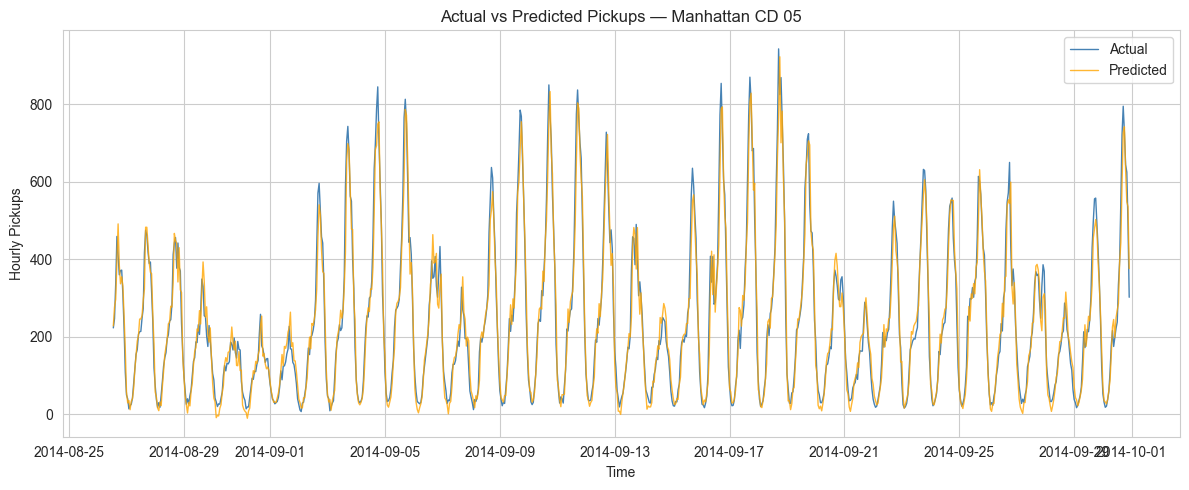

💾 Plot saved to: C:\Users\Monique\Desktop\Model Engineering\taxidemand_forecast\notebooks\figures\02_actual_vs_predicted_Manhattan_CD_05.png
📊 Metrics appended to: C:\Users\Monique\Desktop\Model Engineering\taxidemand_forecast\notebooks\figures\02_baseline_metrics.csv

🔍 First 10 predictions comparison:
   Actual  Predicted  Baseline  Pred_Error  Base_Error
0     223     228.16     184.0       -5.16        39.0
1     247     276.91     223.0      -29.91        24.0
2     337     296.85     247.0       40.15        90.0
3     459     396.91     337.0       62.09       122.0
4     411     491.36     459.0      -80.36       -48.0
5     360     384.32     411.0      -24.32       -51.0
6     371     336.71     360.0       34.29        11.0
7     372     354.92     371.0       17.08         1.0
8     309     331.12     372.0      -22.12       -63.0
9     221     253.60     309.0      -32.60       -88.0


In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os

# ================================
# Define paths
# ================================
BASE_DIR = os.path.abspath("../")
DATA_PROCESSED = os.path.join(BASE_DIR, "data", "processed")

# Figures and logs folder
FIG_DIR = os.path.abspath(os.path.join(os.getcwd(), "figures"))
os.makedirs(FIG_DIR, exist_ok=True)

print(f"📁 Figures & results will be saved to: {FIG_DIR}")

# ================================
# Load train/test data
# ================================
train_path = os.path.join(DATA_PROCESSED, "train.csv")
test_path = os.path.join(DATA_PROCESSED, "test.csv")

train = pd.read_csv(train_path, parse_dates=["pickup_datetime"])
test = pd.read_csv(test_path, parse_dates=["pickup_datetime"])

print(f"Train dataset shape: {train.shape}")
print(f"Test dataset shape: {test.shape}")

# ================================
# 3Select district and sort by time
# ================================
district = "Manhattan CD 05"
train_d = train[train['cd_name'] == district].copy().sort_values('pickup_datetime')
test_d = test[test['cd_name'] == district].copy().sort_values('pickup_datetime')

# ================================
# Recompute lag features
# ================================
print("\n Recomputing lag features correctly...")

for df in [train_d, test_d]:
    df.sort_values('pickup_datetime', inplace=True)
    df['lag_1_corrected'] = df['pickups'].shift(1)
    df['lag_2_corrected'] = df['pickups'].shift(2)
    df['lag_24_corrected'] = df['pickups'].shift(24)
    df['rolling_mean_3h_corrected'] = df['pickups'].shift(1).rolling(window=3, min_periods=1).mean()
    df['rolling_mean_24h_corrected'] = df['pickups'].shift(1).rolling(window=24, min_periods=1).mean()

features_corrected = [
    'sin_hour', 'cos_hour', 'sin_weekday', 'cos_weekday',
    'is_weekend', 'lag_1_corrected', 'lag_2_corrected', 'lag_24_corrected',
    'rolling_mean_3h_corrected', 'rolling_mean_24h_corrected'
]

train_clean = train_d.dropna(subset=features_corrected + ['pickups']).copy()
test_clean = test_d.dropna(subset=features_corrected + ['pickups']).copy()

print(f"\n After cleaning: Train={len(train_clean)} | Test={len(test_clean)}")

# ================================
# Train and evaluate baseline model
# ================================
X_train = train_clean[features_corrected]
y_train = train_clean['pickups']
X_test = test_clean[features_corrected]
y_test = test_clean['pickups']

# Baseline (Lag-1)
baseline_pred = test_clean['lag_1_corrected']
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
print(f"\n📉 Baseline RMSE (Lag-1): {baseline_rmse:.2f}")

# Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
corr = np.corrcoef(y_test, y_pred)[0, 1]

print(f"\n🤖 Linear Regression RMSE: {rmse:.2f}")
print(f"🔗 Correlation: {corr:.3f}")

# ================================
# Visualization
# ================================
plt.figure(figsize=(12, 5))
plt.plot(test_clean['pickup_datetime'], y_test.values, label='Actual', color='steelblue', linewidth=1)
plt.plot(test_clean['pickup_datetime'], y_pred, label='Predicted', color='orange', linewidth=1, alpha=0.8)
plt.title(f"Actual vs Predicted Pickups — {district}")
plt.xlabel("Time")
plt.ylabel("Hourly Pickups")
plt.legend()
plt.tight_layout()

# Save figure
plot_path = os.path.join(FIG_DIR, f"02_actual_vs_predicted_{district.replace(' ', '_')}.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"💾 Plot saved to: {plot_path}")

# ================================
# Save metrics for reproducibility
# ================================
results_path = os.path.join(FIG_DIR, "02_baseline_metrics.csv")
results_df = pd.DataFrame([{
    "district": district,
    "baseline_rmse": baseline_rmse,
    "linear_rmse": rmse,
    "correlation": corr
}])
results_df.to_csv(results_path, mode='a', header=not os.path.exists(results_path), index=False)
print(f"📊 Metrics appended to: {results_path}")

# ================================
# Sample predictions preview
# ================================
print("\n🔍 First 10 predictions comparison:")
comparison = pd.DataFrame({
    'Actual': y_test.values[:10],
    'Predicted': y_pred[:10].round(2),
    'Baseline': baseline_pred.values[:10],
    'Pred_Error': (y_test.values[:10] - y_pred[:10]).round(2),
    'Base_Error': (y_test.values[:10] - baseline_pred.values[:10]).round(2)
})
print(comparison)


The baseline model using the previous hour’s demand (Lag-1) achieved an RMSE of 66.99, providing a reasonable benchmark for short-term persistence forecasting.

The Linear Regression model, which incorporated additional temporal and lag-based predictors, significantly improved accuracy to an RMSE of 43.51 with a correlation of 0.976, demonstrating an excellent alignment between predicted and actual pickup volumes.

Temporal and cyclical variables (hour, weekday, and lag features) emerged as the most influential predictors, confirming strong short-term temporal dependence and regular daily demand cycles across Manhattan.